# Movie Recommendation EDA

## 대회 데이터셋 구성
Movie Rec의 데이터셋 구성입니다.

### data
    ├── train_ratings.csv
    ├── directors.tsv
    ├── genres.tsv
    ├── writers.tsv
    ├── years.tsv
    └── titles.tsv
    
1. *train_ratings.csv* : 전체 훈련 데이터.
- user: 사용자 id.
- item: 영화 id.
- time: 사용자가 해당 영화를 평가한 시간. (UNIX 시간의 초 단위)
2. *directors.tsv*, *genres.tsv*, *writers.tsv*, *years.tsv*, *titles.tsv* : 영화의 side-information 데이터.

- item: 영화 id.(1번의 item과 동일하게 사용)
- director : 영화 감독. (익명)
- genre: 영화 장르.
- writer: 영화 작가. (익명)
- year: 해당 영화가 개봉한 연도.
- title: 영화 제목.

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

## 1. User - Item Interaction Data

In [13]:
data_path = '../../data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [14]:
#info: type과 데이터 크기를 봄
#head: 데이터 구성을 파악
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [15]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)

print ("Number of unique train items: ", num_train_items)

Number of unique train users:  31360
Number of unique train items:  6807


In [16]:
def check_duplicates(df, lst):
    duplicates = df[df.duplicated(subset=lst)]

    if duplicates.empty:
        print('중복된 데이터가 없습니다.')
    else:
        print('중복된 데이터:')
        print(duplicates)


check_duplicates(train_df, ['user', 'item'])

#한 유저가 동일한 시간에 영화를 평가한 기록이 있다.
check_duplicates(train_df, ['user', 'time'])

중복된 데이터가 없습니다.
중복된 데이터:
           user   item        time
85           11   1196  1230787560
3053        121   1210  1300766825
3989        136  89745  1415635487
6735        239   3996  1245047088
6758        239    356  1245047491
...         ...    ...         ...
5149531  138392   2028  1239957921
5149532  138392   1196  1239957921
5152277  138437   6187  1193641021
5152800  138456    539  1183781135
5153357  138470  58559  1227334860

[9306 rows x 3 columns]


In [17]:
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


In [18]:
# train_df의 "time" 열을 Unix 시간에서 날짜 및 년도로 변환
train_df['time'] = pd.to_datetime(train_df['time'], unit='s').dt.year

In [19]:
train_df

,user,item,time
0,11,4643,2009
1,11,170,2009
2,11,531,2009
3,11,616,2009
4,11,2140,2009
...,...,...,...
5154466,138493,44022,2009
5154467,138493,4958,2009
5154468,138493,68319,2009
5154469,138493,40819,2009


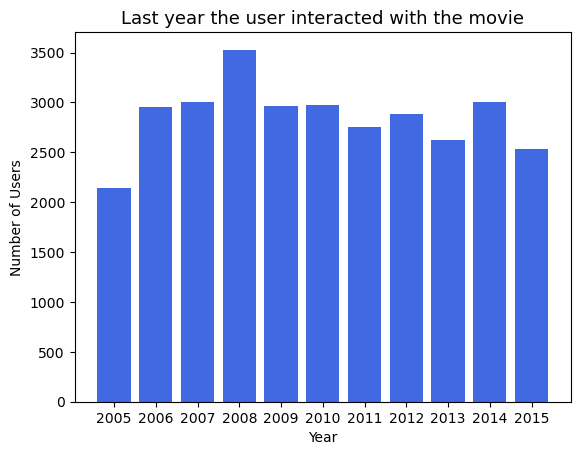

In [20]:
# train_df를 유저별로 묶고 가장 큰 년도의 값 추출
max_year_per_user = train_df.groupby('user')['time'].max()
max_year_per_user = max_year_per_user.reset_index()

#해당 연도에 마지막으로 영화를 평가한 사용자 수
max_year_users = max_year_per_user.groupby('time').size().reset_index()
max_year_users.columns = ['year', 'user_count']

# 선 그래프로 시각화
plt.bar(max_year_users['year'], max_year_users['user_count'], color = 'royalblue')
plt.xlabel('Year')
plt.ylabel('Number of Users')
plt.title('Last year the user interacted with the movie', fontsize=13)
plt.xticks(max_year_users['year'])
plt.show()

## 2. Side Information

In [21]:
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')


In [22]:
#중복 검사
check_duplicates(director_data, ['item','director'])
check_duplicates(genre_data, ['item','genre'])
check_duplicates(writer_data, ['item','writer'])
check_duplicates(year_data, ['item','year'])
check_duplicates(title_data, ['item','title'])

중복된 데이터가 없습니다.
중복된 데이터가 없습니다.
중복된 데이터가 없습니다.
중복된 데이터가 없습니다.
중복된 데이터가 없습니다.


### 영화 감독

In [23]:
director_data.info()
director_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


,item,director
698,2144,nm0000455
446,6387,nm0000247
4023,46972,nm0506613


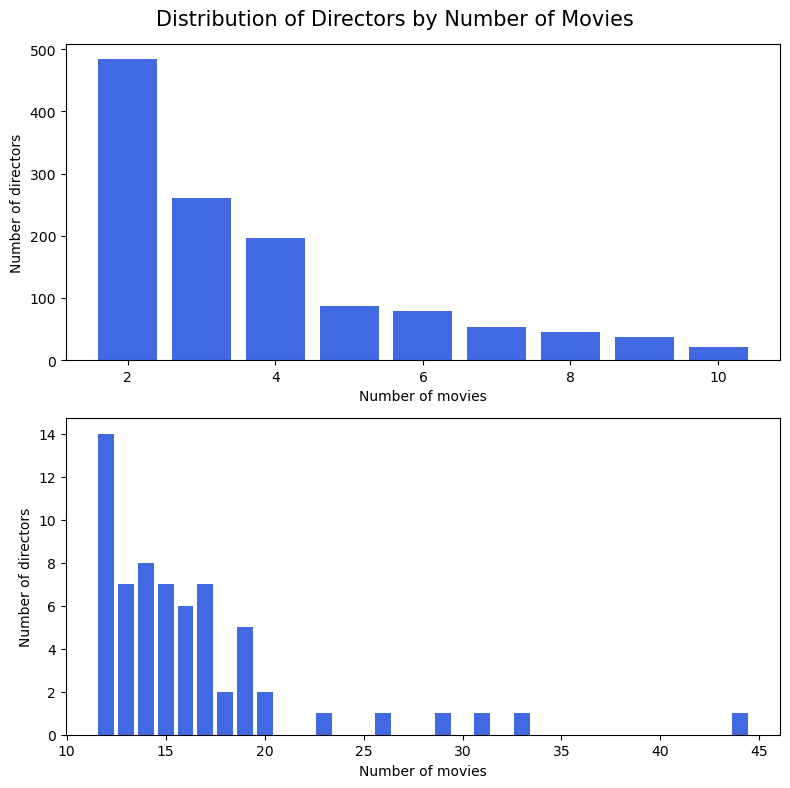

In [24]:
director_df = director_data.groupby('director').size().reset_index()
director_df.columns  = ['director','count']
director_df = director_df.groupby('count').size().reset_index()
director_df.columns  = ['count','num_director']
director_df = director_df.sort_values('count',ascending=True)

# Create a figure and two subplots vertically stacked
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# First subplot
ax1.bar(director_df['count'][:9], director_df['num_director'][:9], color='royalblue')
ax1.set_xlabel('Number of movies')
ax1.set_ylabel('Number of directors')

# Second subplot
ax2.bar(director_df['count'][10:], director_df['num_director'][10:], color='royalblue')
ax2.set_xlabel('Number of movies')
ax2.set_ylabel('Number of directors')

plt.suptitle('Distribution of Directors by Number of Movies',fontsize=15)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

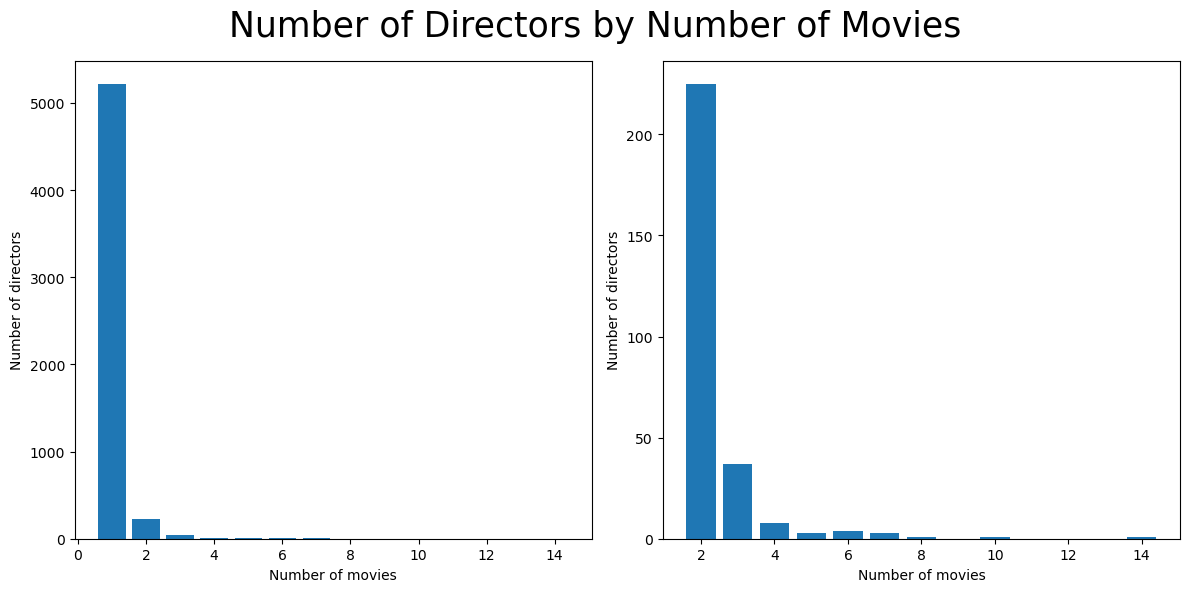

In [25]:
#영화별로 감독 수
grouped_counts = director_data.groupby('item').size().reset_index(name = 'count')
grouped_counts = grouped_counts.groupby('count').size().reset_index()
grouped_counts.columns = ['num_movies', 'num_directors']

# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot
ax1.bar(grouped_counts['num_movies'], grouped_counts['num_directors'])
ax1.set_xlabel('Number of movies')
ax1.set_ylabel('Number of directors')

# Second subplot
ax2.bar(grouped_counts['num_movies'][1:], grouped_counts['num_directors'][1:])
ax2.set_xlabel('Number of movies')
ax2.set_ylabel('Number of directors')

# Set the unified title
plt.suptitle('Number of Directors by Number of Movies',fontsize=25)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### 영화 장르

In [26]:
genre_data.info()
genre_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


,item,genre
0,318,Crime
1,318,Drama
2,2571,Action


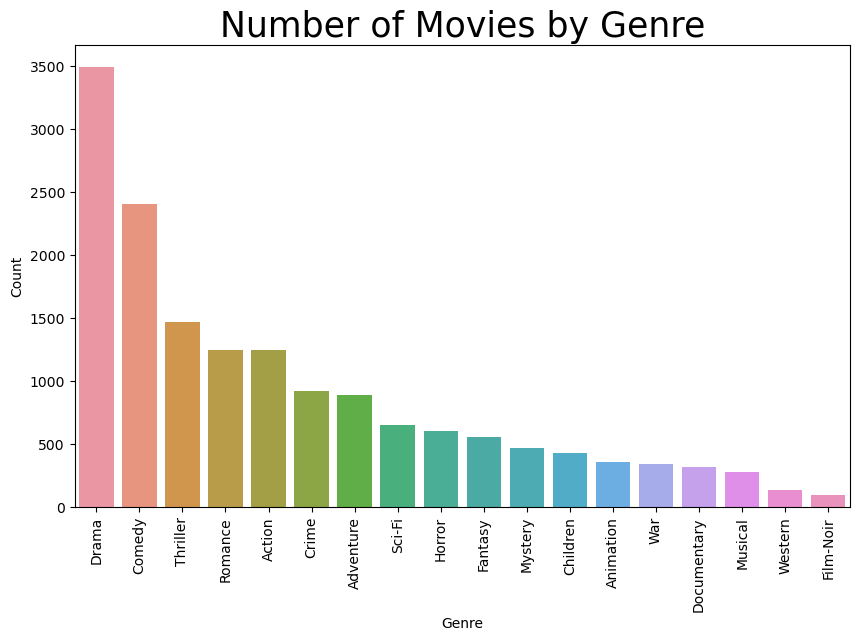

In [27]:
# Group the data by genre and count the number of items in each genre
grouped_counts = genre_data.groupby('genre').size().reset_index(name='count')
grouped_counts = grouped_counts.sort_values('count', ascending=False)
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x='genre', y='count', data=grouped_counts)

# Adding labels and title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Movies by Genre', fontsize=25)

# Rotating x-axis labels if needed
plt.xticks(rotation=90)

# Display the bar plot
plt.show()

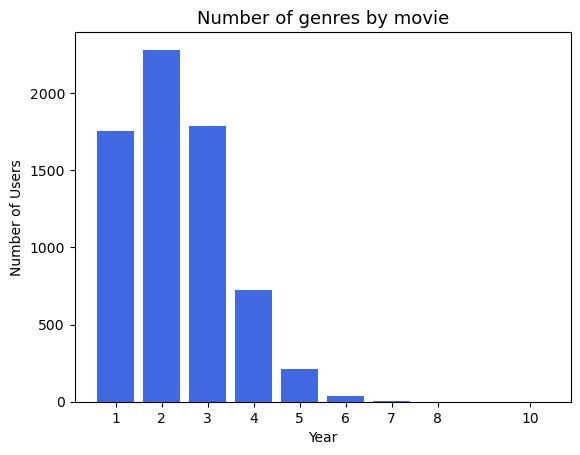

In [28]:
# Group the data by genre and count the number of items in each genre
grouped_counts = genre_data.groupby('item').size().reset_index(name='num_genres')
grouped_counts = grouped_counts.sort_values('num_genres')
grouped_counts = grouped_counts.groupby('num_genres').size().reset_index(name='num_movies')

# 선 그래프로 시각화
plt.bar(grouped_counts['num_genres'], grouped_counts['num_movies'], color = 'royalblue')
plt.xlabel('Year')
plt.ylabel('Number of Users')
plt.title('Number of genres by movie', fontsize=13)
plt.xticks(grouped_counts['num_genres'])
plt.show()

### 영화 작가

In [29]:
writer_data.info()
writer_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


,item,writer
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005


In [30]:
#영화별로 묶어서 영화별 작가 수 확인
grouped_counts = writer_data.groupby('item').size().reset_index()

grouped_counts.info()
grouped_counts.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5648 entries, 0 to 5647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    5648 non-null   int64
 1   0       5648 non-null   int64
dtypes: int64(2)
memory usage: 88.4 KB


,item,0
count,5648.000000,5648.000000
mean,24782.574894,2.001771
std,31551.705396,1.546859
min,1.000000,1.000000
25%,2804.750000,1.000000
50%,6407.000000,2.000000
75%,45506.500000,2.000000
max,119145.000000,24.000000


### 영화가 개봉한 연도

In [31]:
year_data.info()
year_data.head(3)
year_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


,item,year
count,6799.000000,6799.000000
mean,26630.017503,1992.174732
std,32187.872806,19.052568
min,1.000000,1922.000000
25%,3052.500000,1985.000000
50%,6879.000000,1999.000000
75%,49840.000000,2006.000000
max,119141.000000,2014.000000


In [32]:
print("Number of unique years: ", year_data['year'].nunique())

Number of unique years:  93


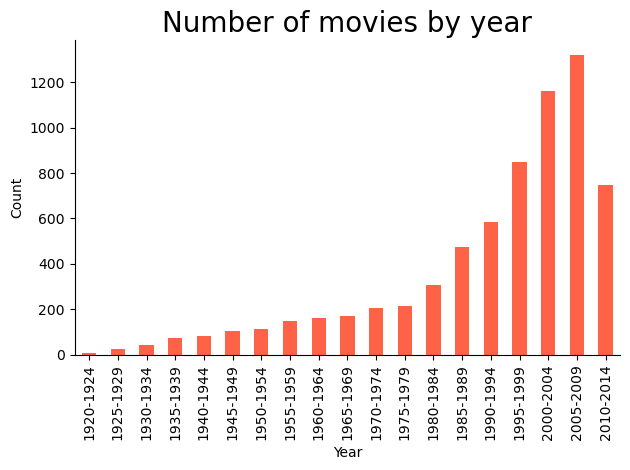

In [33]:
year_counts = year_data.groupby('year').size().reset_index(name = 'count')
year_counts = year_counts.sort_values('count')

# Define the bins and labels for the 5-year intervals
bins = range(1920, 2020, 5)
labels = [f'{start}-{start + 4}' for start in bins[:-1]]

# Apply the bins and labels to the 'year' column
year_counts['Year Group'] = pd.cut(year_counts['year'], bins=bins, labels=labels, right=False)

# Group by the new Year Group and calculate the sum of counts
grouped_counts = year_counts.groupby('Year Group')['count'].sum()

# Plot the bar graph
grouped_counts.plot(kind='bar', color='tomato')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of movies by year', fontsize = 20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

### 영화 제목

In [34]:
title_data.info()
title_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)


## Merge Data

In [35]:
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')

In [36]:
# 하나의 영화에 두 개이상의 장르 정보를 모두 사용하기 위해 영화로 묶고 나머지 아이템을 리스트로 묶음.

director_data = director_data.groupby('item')['director'].apply(list).reset_index(name='directors')
writer_data = writer_data.groupby('item')['writer'].apply(list).reset_index(name='writers')
genre_data = genre_data.groupby('item')['genre'].apply(list).reset_index(name='genres')

In [37]:
#merge로 인한 데이터 손실 발생. item 정보가 다 있는 것만 사용.
merged_df = train_df.merge(director_data, on='item').merge(genre_data, on='item').merge(writer_data, on='item').merge(year_data, on='item').merge(title_data, on='item')
merged_df

,user,item,time,directors,genres,writers,year,title
0,11,4643,1230782529,[nm0000318],"[Action, Adventure, Drama, Sci-Fi]","[nm0099541, nm0115310, nm0465199, nm0742797]",2001,Planet of the Apes (2001)
1,189,4643,1302945016,[nm0000318],"[Action, Adventure, Drama, Sci-Fi]","[nm0099541, nm0115310, nm0465199, nm0742797]",2001,Planet of the Apes (2001)
2,294,4643,1288437662,[nm0000318],"[Action, Adventure, Drama, Sci-Fi]","[nm0099541, nm0115310, nm0465199, nm0742797]",2001,Planet of the Apes (2001)
3,383,4643,1261996844,[nm0000318],"[Action, Adventure, Drama, Sci-Fi]","[nm0099541, nm0115310, nm0465199, nm0742797]",2001,Planet of the Apes (2001)
4,421,4643,1190624541,[nm0000318],"[Action, Adventure, Drama, Sci-Fi]","[nm0099541, nm0115310, nm0465199, nm0742797]",2001,Planet of the Apes (2001)
...,...,...,...,...,...,...,...,...
4658294,126426,102880,1386260290,[nm0796117],"[Action, Adventure, Sci-Fi]","[nm0796117, nm1729428]",2013,After Earth (2013)
4658295,127766,102880,1386261575,[nm0796117],"[Action, Adventure, Sci-Fi]","[nm0796117, nm1729428]",2013,After Earth (2013)
4658296,130972,102880,1391096866,[nm0796117],"[Action, Adventure, Sci-Fi]","[nm0796117, nm1729428]",2013,After Earth (2013)
4658297,131347,102880,1370143675,[nm0796117],"[Action, Adventure, Sci-Fi]","[nm0796117, nm1729428]",2013,After Earth (2013)


In [38]:
join_df = train_df.join(director_data.set_index('item'), on='item')
join_df = join_df.join(genre_data.set_index('item'), on='item')
join_df = join_df.join(writer_data.set_index('item'), on='item')
join_df = join_df.join(year_data.set_index('item'), on='item')
join_df = join_df.join(title_data.set_index('item'), on='item')
join_df

,user,item,time,directors,genres,writers,year,title
0,11,4643,1230782529,[nm0000318],"[Action, Adventure, Drama, Sci-Fi]","[nm0099541, nm0115310, nm0465199, nm0742797]",2001.0,Planet of the Apes (2001)
1,11,170,1230782534,[nm0812200],"[Action, Adventure, Crime, Thriller]",NaN,1995.0,Hackers (1995)
2,11,531,1230782539,[nm0002140],"[Children, Drama]","[nm0003031, nm0122364]",1993.0,"Secret Garden, The (1993)"
3,11,616,1230782542,[nm0718627],"[Animation, Children]","[nm0027011, nm0166307, nm0166551, nm0314788, n...",1970.0,"Aristocats, The (1970)"
4,11,2140,1230782563,"[nm0000568, nm0001345]","[Adventure, Fantasy]","[nm0001345, nm0643973]",1982.0,"Dark Crystal, The (1982)"
...,...,...,...,...,...,...,...,...
5154466,138493,44022,1260209449,[nm0757858],"[Adventure, Animation, Children, Comedy]","[nm0310087, nm0841532, nm5022110]",2006.0,Ice Age 2: The Meltdown (2006)
5154467,138493,4958,1260209482,[nm0601382],"[Action, Drama, War]","[nm0672015, nm0859029, nm0859049, nm0892705]",2001.0,Behind Enemy Lines (2001)
5154468,138493,68319,1260209720,[nm0004303],"[Action, Sci-Fi, Thriller]","[nm0940790, nm1125275]",2009.0,X-Men Origins: Wolverine (2009)
5154469,138493,40819,1260209726,[nm0003506],"[Drama, Musical, Romance]","[nm0003506, nm0219456]",2005.0,Walk the Line (2005)


In [39]:
top_users = join_df['user'].value_counts().reset_index(name='num_movies')[:10]
top_users

,index,num_movies
0,8405,2912
1,54465,1980
2,24219,1842
3,32514,1830
4,91349,1795
5,131904,1762
6,34576,1760
7,99754,1673
8,31122,1644
9,118754,1627


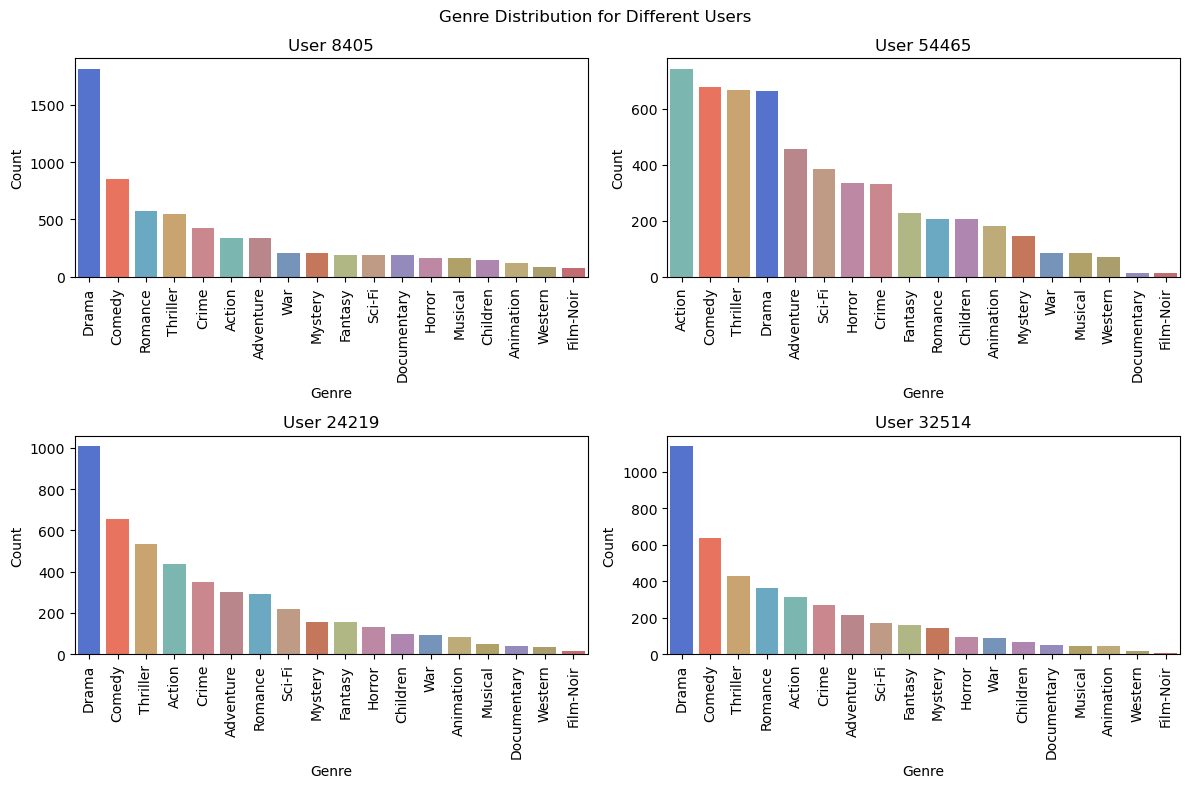

In [40]:
# 유저별로 선호하는 장르 표현
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Genre Distribution for Different Users')

users = [8405, 54465, 24219, 32514]

# 장르별 색상 고정 (파스텔 톤, 좀 더 진하게 조정)
genre_colors = {
    'Crime': '#D57C85',
    'Film-Noir': '#D05F66',
    'Mystery': '#D66F48',
    'Thriller': '#D9A661',
    'Comedy': 'Tomato',
    'Fantasy': '#B7C07B',
    'Drama': 'royalblue',
    'Action': '#72C0B7',
    'Romance': '#5CAED0',
    'War': '#6B91C5',
    'Documentary': '#8F83C4',
    'Children': '#B67FB7',
    'Horror': '#C57FA3',
    'Adventure': '#C17D85',
    'Sci-Fi': '#C9987B',
    'Animation': '#C8B16E',
    'Western': '#B4A662',
    'Musical': '#BBA85B'
}


# 각 사용자에 대한 그래프 그리기
for i, user in enumerate(users):
    ax = axes[i // 2, i % 2]

    user_data = join_df[join_df['user'] == user]
    genre_list = list(itertools.chain.from_iterable(user_data['genres']))
    genre_counts = collections.Counter(genre_list)

    sorted_genre_counts = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
    genres, counts = zip(*sorted_genre_counts)
    
    # 장르에 고정된 색상 리스트 생성
    genre_palette = [genre_colors.get(genre, 'gray') for genre in genres]

    # barplot 그리기
    sns.barplot(x=list(genres), y=list(counts), ax=ax, palette=genre_palette)
    ax.set_xlabel('Genre')
    ax.set_ylabel('Count')
    ax.set_title(f"User {user}")
    ax.tick_params(axis='x', rotation=90)

# 서브플롯 간 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()
